In [3]:
import pandas
import time
from scipy.stats import lognorm
from sklearn.preprocessing import StandardScaler
import numpy as np
seed = 71
np.random.seed = seed

import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

from qiskit import Aer, QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal, UniformDistribution, NormalDistribution

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import NumPyDiscriminator, QGAN

from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation
from qiskit.finance.applications import EuropeanCallExpectedValue

algorithm_globals.random_seed = seed

C:\Users\user\anaconda3\lib\site-packages\qiskit\aqua\__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
C:\Users\user\anaconda3\lib\site-packages\qiskit\finance\__init__.py:50: DeprecationWarning: The package qiskit.finance is deprecated. It was moved/refactored to qiskit_finance (pip install qiskit-finance). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('finance', 'qiskit_finance', 'qiskit-finance')


In [ ]:
ep_list_1 = []
ep_train_list_1 =[]
estimate_list_1 = []
times_list_1 = []
in_ci_1 = 0
run_time_1 = 0

for times in range(1, 101):
    
    start = time.process_time()
    
    N = 1000
    qubits_num = 3
    num_epochs = 5
    
    data = []
    data = pandas.read_csv("ttt.csv", names=["price"])
    scaler = StandardScaler()
    data_list = scaler.fit_transform(data)
    data_arr = np.array(data_list)
    actual_data = data_arr.astype(float)
    
    sigma,loc,scale = stats.lognorm.fit(actual_data)
    estimated_mu = np.log(scale)
    estimated_sigma = sigma
    real_data = np.random.lognormal(mean=estimated_mu, sigma=estimated_sigma, size=N)

    Dmin = real_data.min()
    Dmax = real_data.max()
    
    load_num_qubits = [qubits_num]
    k = len(load_num_qubits)
    load_bounds = np.array([0, (2 ** load_num_qubits[0]) -1])

    batch_size = int(N/num_epochs)
    qgan = QGAN(real_data, load_bounds, load_num_qubits, batch_size, num_epochs, snapshot_dir=None)
    qgan.seed = 11
    quantum_instance = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'),
                                   seed_transpiler=seed, seed_simulator=seed)

    init_dist = UniformDistribution(sum(load_num_qubits))
    ansatz = TwoLocal(int(np.sum(load_num_qubits)), 'ry', 'cz', 'linear', reps=1, insert_barriers=True)
    init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi
    load_g_circuit = ansatz.compose(init_dist, front=True)

    qgan.set_generator(generator_circuit=load_g_circuit, generator_init_params=init_params)
    qgan._generator._free_parameters = sorted(load_g_circuit.parameters, key=lambda p: p.name)
    discriminator = NumPyDiscriminator(len(load_num_qubits))
    qgan.set_discriminator(discriminator)

    result = qgan.run(quantum_instance)
    
    op_bounds = np.array([0 , (2 ** load_num_qubits[0]) -1])
    op_num_qubits = load_num_qubits[0]
    g_params = result['params_g']
    init_dist = NormalDistribution(op_num_qubits, mu=estimated_mu, sigma=estimated_sigma, bounds=op_bounds)
    var_form = TwoLocal(op_num_qubits, 'ry', 'cz', entanglement='circular', reps=1)
    theta = var_form.ordered_parameters
    op_g_circuit = init_dist.compose(var_form)

    strike_price = 2
    c_approx = 0.25
    european_call_objective = EuropeanCallExpectedValue(
        op_num_qubits,
        strike_price=strike_price,
        rescaling_factor=c_approx,
        bounds=op_bounds
    )
    
    values = [op_bounds[0] + (op_bounds[1] - op_bounds[0]) * x / (2 ** op_num_qubits - 1) for x in range(2**op_num_qubits)]
    uncertainty_model = op_g_circuit.assign_parameters(dict(zip(theta, g_params)))
    amplitudes = Statevector.from_instruction(uncertainty_model).data

    x = np.array(values)
    y = np.abs(amplitudes) ** 2

    N = 100000
    log_normal = np.random.lognormal(mean=estimated_mu, sigma=estimated_sigma, size=N)
    log_normal = np.round(log_normal)
    log_normal = log_normal[log_normal <= (2 ** op_num_qubits) -1]
    log_normal_samples = []
    for i in range(2 ** op_num_qubits):
        log_normal_samples += [np.sum(log_normal==i)]
    log_normal_samples = np.array(log_normal_samples / sum(log_normal_samples))

    payoff = []
    for i in range(2 ** op_num_qubits):
        if i <= strike_price:
            payoff.append(0)
        else:
            payoff.append(i - strike_price)
    payoff = np.array(payoff)

    ep = np.dot(log_normal_samples, payoff)
    ep_trained = np.dot(y, payoff)
    european_call = european_call_objective.compose(uncertainty_model, front=True)
    epsilon = 0.01
    alpha = 0.05

    ae = IterativeAmplitudeEstimation(epsilon=epsilon, alpha=alpha,
                                      state_preparation=european_call,
                                      objective_qubits=[op_num_qubits],
                                      post_processing=european_call_objective.post_processing)
    END_result = ae.run(quantum_instance = Aer.get_backend('qasm_simulator'), shots = 1000)
    
    conf_int = np.array(END_result['confidence_interval'])
    print('Target value:       \t%.4f' % ep)
    print('Exact value:        \t%.4f' % ep_trained)
    print('Estimated value:    \t%.4f' % (END_result['estimation']))
    print('Confidence interval:\t[%.4f, %.4f]' % tuple(conf_int))
    print(times)
    print(num_epochs)
    end = time.process_time()
    print("執行時間：%f 秒" % (end - start))

    if conf_int[0] <= ep <= conf_int[1]:
        in_ci_1 += 1
        
    run_time_1 += (end - start)
    ep_list_1.append(ep)
    ep_train_list_1.append(ep_trained)
    estimate_list_1.append((END_result['estimation']))
    times_list_1.append(times)

C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6291
Exact value:        	2.5690
Estimated value:    	2.5498
Confidence interval:	[2.5000, 2.5995]
1
5
執行時間：18.187500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6362
Exact value:        	1.9701
Estimated value:    	2.0083
Confidence interval:	[1.9475, 2.0692]
2
5
執行時間：18.406250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6276
Exact value:        	1.6960
Estimated value:    	1.6640
Confidence interval:	[1.5860, 1.7421]
3
5
執行時間：21.828125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6270
Exact value:        	1.1584
Estimated value:    	1.1967
Confidence interval:	[1.1652, 1.2283]
4
5
執行時間：18.500000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6291
Exact value:        	1.7581
Estimated value:    	1.7695
Confidence interval:	[1.6914, 1.8475]
5
5
執行時間：18.359375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6322
Exact value:        	0.7530
Estimated value:    	0.7868
Confidence interval:	[0.7388, 0.8347]
6
5
執行時間：19.015625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6263
Exact value:        	0.0303
Estimated value:    	0.0961
Confidence interval:	[0.0622, 0.1299]
7
5
執行時間：19.531250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6286
Exact value:        	3.5611
Estimated value:    	3.5913
Confidence interval:	[3.4829, 3.6998]
8
5
執行時間：18.203125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6330
Exact value:        	2.2115
Estimated value:    	2.2252
Confidence interval:	[2.1754, 2.2750]
9
5
執行時間：19.296875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6258
Exact value:        	3.0272
Estimated value:    	3.0028
Confidence interval:	[2.9419, 3.0636]
10
5
執行時間：19.140625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6275
Exact value:        	2.3204
Estimated value:    	2.2927
Confidence interval:	[2.2562, 2.3293]
11
5
執行時間：20.140625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6325
Exact value:        	2.6108
Estimated value:    	2.6329
Confidence interval:	[2.5831, 2.6827]
12
5
執行時間：20.062500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6297
Exact value:        	2.4099
Estimated value:    	2.3848
Confidence interval:	[2.3351, 2.4346]
13
5
執行時間：19.593750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6301
Exact value:        	3.0165
Estimated value:    	3.0016
Confidence interval:	[2.9517, 3.0515]
14
5
執行時間：19.765625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6275
Exact value:        	0.2468
Estimated value:    	0.3032
Confidence interval:	[0.2730, 0.3334]
15
5
執行時間：19.890625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6363
Exact value:        	2.1088
Estimated value:    	2.1716
Confidence interval:	[2.0935, 2.2498]
16
5
執行時間：18.156250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6263
Exact value:        	3.3267
Estimated value:    	3.3061
Confidence interval:	[3.1972, 3.4150]
17
5
執行時間：17.578125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6297
Exact value:        	0.4855
Estimated value:    	0.5338
Confidence interval:	[0.5030, 0.5647]
18
5
執行時間：19.640625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6282
Exact value:        	0.7989
Estimated value:    	0.7952
Confidence interval:	[0.7546, 0.8358]
19
5
執行時間：19.062500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6324
Exact value:        	0.1296
Estimated value:    	0.2017
Confidence interval:	[0.1450, 0.2585]
20
5
執行時間：18.343750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6327
Exact value:        	0.2290
Estimated value:    	0.2763
Confidence interval:	[0.2193, 0.3333]
21
5
執行時間：18.328125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6262
Exact value:        	1.7197
Estimated value:    	1.7951
Confidence interval:	[1.7171, 1.8732]
22
5
執行時間：18.062500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6313
Exact value:        	0.7873
Estimated value:    	0.8578
Confidence interval:	[0.8171, 0.8985]
23
5
執行時間：18.968750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6358
Exact value:        	0.7128
Estimated value:    	0.7260
Confidence interval:	[0.6855, 0.7665]
24
5
執行時間：18.984375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6319
Exact value:        	2.1428
Estimated value:    	2.1325
Confidence interval:	[2.0544, 2.2107]
25
5
執行時間：17.968750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6277
Exact value:        	0.9463
Estimated value:    	0.9803
Confidence interval:	[0.9394, 1.0212]
26
5
執行時間：19.093750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6275
Exact value:        	0.9553
Estimated value:    	0.9790
Confidence interval:	[0.9435, 1.0145]
27
5
執行時間：19.468750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6291
Exact value:        	3.9232
Estimated value:    	3.8874
Confidence interval:	[3.8463, 3.9285]
28
5
執行時間：19.109375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6272
Exact value:        	2.1597
Estimated value:    	2.1580
Confidence interval:	[2.0799, 2.2362]
29
5
執行時間：18.203125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6281
Exact value:        	0.3108
Estimated value:    	0.3613
Confidence interval:	[0.3040, 0.4186]
30
5
執行時間：18.375000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6321
Exact value:        	0.4012
Estimated value:    	0.4676
Confidence interval:	[0.4204, 0.5149]
31
5
執行時間：18.765625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6313
Exact value:        	2.1883
Estimated value:    	2.1831
Confidence interval:	[2.1223, 2.2439]
32
5
執行時間：18.296875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6345
Exact value:        	4.8656
Estimated value:    	4.8251
Confidence interval:	[4.7685, 4.8818]
33
5
執行時間：22.640625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6284
Exact value:        	1.4650
Estimated value:    	1.4759
Confidence interval:	[1.3673, 1.5844]
34
5
執行時間：17.765625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6303
Exact value:        	1.6748
Estimated value:    	1.7024
Confidence interval:	[1.6701, 1.7346]
35
5
執行時間：20.015625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6269
Exact value:        	2.7474
Estimated value:    	2.7327
Confidence interval:	[2.6829, 2.7825]
36
5
執行時間：18.640625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6303
Exact value:        	1.1725
Estimated value:    	1.2076
Confidence interval:	[1.1663, 1.2489]
37
5
執行時間：19.062500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6298
Exact value:        	0.4001
Estimated value:    	0.4555
Confidence interval:	[0.4083, 0.5027]
38
5
執行時間：18.828125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6266
Exact value:        	1.5223
Estimated value:    	1.5222
Confidence interval:	[1.4859, 1.5584]
39
5
執行時間：19.218750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6219
Exact value:        	0.8335
Estimated value:    	0.8355
Confidence interval:	[0.7875, 0.8836]
40
5
執行時間：18.750000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6290
Exact value:        	1.1481
Estimated value:    	1.1963
Confidence interval:	[1.1606, 1.2320]
41
5
執行時間：19.312500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6262
Exact value:        	0.4750
Estimated value:    	0.5256
Confidence interval:	[0.4782, 0.5729]
42
5
執行時間：18.781250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6364
Exact value:        	0.4198
Estimated value:    	0.4662
Confidence interval:	[0.4258, 0.5066]
43
5
執行時間：19.203125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6344
Exact value:        	3.3996
Estimated value:    	3.4017
Confidence interval:	[3.3236, 3.4798]
44
5
執行時間：18.078125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6331
Exact value:        	1.9203
Estimated value:    	1.9592
Confidence interval:	[1.8983, 2.0200]
45
5
執行時間：19.406250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6275
Exact value:        	2.1975
Estimated value:    	2.1989
Confidence interval:	[2.1491, 2.2487]
46
5
執行時間：19.515625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6301
Exact value:        	0.0648
Estimated value:    	0.1246
Confidence interval:	[0.0681, 0.1810]
47
5
執行時間：18.875000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6301
Exact value:        	0.4150
Estimated value:    	0.4868
Confidence interval:	[0.4396, 0.5341]
48
5
執行時間：19.156250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6325
Exact value:        	2.5329
Estimated value:    	2.5486
Confidence interval:	[2.4988, 2.5984]
49
5
執行時間：19.078125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6353
Exact value:        	3.2938
Estimated value:    	3.2787
Confidence interval:	[3.2007, 3.3568]
50
5
執行時間：18.078125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6332
Exact value:        	0.9411
Estimated value:    	0.9643
Confidence interval:	[0.9159, 1.0126]
51
5
執行時間：22.921875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6267
Exact value:        	0.5815
Estimated value:    	0.6176
Confidence interval:	[0.5700, 0.6651]
52
5
執行時間：18.671875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6319
Exact value:        	0.4617
Estimated value:    	0.5010
Confidence interval:	[0.4537, 0.5483]
53
5
執行時間：18.890625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6324
Exact value:        	0.4762
Estimated value:    	0.5092
Confidence interval:	[0.4619, 0.5565]
54
5
執行時間：18.671875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6274
Exact value:        	0.9794
Estimated value:    	1.0118
Confidence interval:	[0.9762, 1.0473]
55
5
執行時間：19.718750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6355
Exact value:        	3.3312
Estimated value:    	3.3893
Confidence interval:	[3.3278, 3.4508]
56
5
執行時間：22.703125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6257
Exact value:        	2.1752
Estimated value:    	2.1737
Confidence interval:	[2.1129, 2.2345]
57
5
執行時間：18.531250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6307
Exact value:        	0.3989
Estimated value:    	0.4272
Confidence interval:	[0.3800, 0.4743]
58
5
執行時間：18.718750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6296
Exact value:        	2.9640
Estimated value:    	2.9398
Confidence interval:	[2.8616, 3.0179]
59
5
執行時間：18.375000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6270
Exact value:        	0.4003
Estimated value:    	0.4583
Confidence interval:	[0.4006, 0.5159]
60
5
執行時間：18.562500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6246
Exact value:        	2.3873
Estimated value:    	2.3842
Confidence interval:	[2.3477, 2.4207]
61
5
執行時間：24.125000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6381
Exact value:        	0.7299
Estimated value:    	0.7901
Confidence interval:	[0.7422, 0.8381]
62
5
執行時間：19.390625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6254
Exact value:        	2.8566
Estimated value:    	2.9033
Confidence interval:	[2.8251, 2.9814]
63
5
執行時間：18.656250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6274
Exact value:        	0.4476
Estimated value:    	0.5092
Confidence interval:	[0.4619, 0.5565]
64
5
執行時間：23.875000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6274
Exact value:        	0.8859
Estimated value:    	0.9013
Confidence interval:	[0.8605, 0.9421]
65
5
執行時間：19.640625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6316
Exact value:        	1.7364
Estimated value:    	1.7572
Confidence interval:	[1.6962, 1.8183]
66
5
執行時間：18.656250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6313
Exact value:        	2.5789
Estimated value:    	2.5945
Confidence interval:	[2.5523, 2.6366]
67
5
執行時間：19.687500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6296
Exact value:        	3.1337
Estimated value:    	3.0969
Confidence interval:	[3.0189, 3.1750]
68
5
執行時間：18.593750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6322
Exact value:        	0.1092
Estimated value:    	0.1836
Confidence interval:	[0.1536, 0.2136]
69
5
執行時間：20.031250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6296
Exact value:        	2.8659
Estimated value:    	2.8393
Confidence interval:	[2.7971, 2.8815]
70
5
執行時間：19.750000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6356
Exact value:        	2.8812
Estimated value:    	2.8843
Confidence interval:	[2.8234, 2.9451]
71
5
執行時間：19.078125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6376
Exact value:        	2.2750
Estimated value:    	2.2871
Confidence interval:	[2.2449, 2.3292]
72
5
執行時間：19.515625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6309
Exact value:        	2.8044
Estimated value:    	2.7661
Confidence interval:	[2.7052, 2.8269]
73
5
執行時間：18.828125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6263
Exact value:        	1.7576
Estimated value:    	1.7712
Confidence interval:	[1.7102, 1.8322]
74
5
執行時間：18.843750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6354
Exact value:        	3.0403
Estimated value:    	3.0292
Confidence interval:	[2.9684, 3.0901]
75
5
執行時間：19.125000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6309
Exact value:        	2.8770
Estimated value:    	2.8940
Confidence interval:	[2.8518, 2.9362]
76
5
執行時間：19.546875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6330
Exact value:        	2.5457
Estimated value:    	2.5245
Confidence interval:	[2.4823, 2.5666]
77
5
執行時間：19.937500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6315
Exact value:        	2.9730
Estimated value:    	2.9686
Confidence interval:	[2.8905, 3.0468]
78
5
執行時間：18.921875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6271
Exact value:        	3.8518
Estimated value:    	3.8119
Confidence interval:	[3.7804, 3.8435]
79
5
執行時間：20.781250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6303
Exact value:        	1.4876
Estimated value:    	1.5040
Confidence interval:	[1.4678, 1.5402]
80
5
執行時間：19.984375 秒


In [9]:
ep_list_2 = []
ep_train_list_2 =[]
estimate_list_2 = []
times_list_2 = []
in_ci_2 = 0
run_time_2 = 0

for times in range(1, 101):
    
    start = time.process_time()
    
    N = 1000
    qubits_num = 3
    num_epochs = 10
    
    data = []
    data = pandas.read_csv("ttt.csv", names=["price"])
    scaler = StandardScaler()
    data_list = scaler.fit_transform(data)
    data_arr = np.array(data_list)
    actual_data = data_arr.astype(float)
    
    sigma,loc,scale = stats.lognorm.fit(actual_data)
    estimated_mu = np.log(scale)
    estimated_sigma = sigma
    real_data = np.random.lognormal(mean=estimated_mu, sigma=estimated_sigma, size=N)

    Dmin = real_data.min()
    Dmax = real_data.max()
    
    load_num_qubits = [qubits_num]
    k = len(load_num_qubits)
    load_bounds = np.array([0, (2 ** load_num_qubits[0]) -1])

    batch_size = int(N/num_epochs)
    qgan = QGAN(real_data, load_bounds, load_num_qubits, batch_size, num_epochs, snapshot_dir=None)
    qgan.seed = 11
    quantum_instance = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'),
                                   seed_transpiler=seed, seed_simulator=seed)

    init_dist = UniformDistribution(sum(load_num_qubits))
    ansatz = TwoLocal(int(np.sum(load_num_qubits)), 'ry', 'cz', 'linear', reps=1, insert_barriers=True)
    init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi
    load_g_circuit = ansatz.compose(init_dist, front=True)

    qgan.set_generator(generator_circuit=load_g_circuit, generator_init_params=init_params)
    qgan._generator._free_parameters = sorted(load_g_circuit.parameters, key=lambda p: p.name)
    discriminator = NumPyDiscriminator(len(load_num_qubits))
    qgan.set_discriminator(discriminator)
    
    result = qgan.run(quantum_instance)
    
    op_bounds = np.array([0 , (2 ** load_num_qubits[0]) -1])
    op_num_qubits = load_num_qubits[0]
    g_params = result['params_g']
    init_dist = NormalDistribution(op_num_qubits, mu=estimated_mu, sigma=estimated_sigma, bounds=op_bounds)
    var_form = TwoLocal(op_num_qubits, 'ry', 'cz', entanglement='circular', reps=1)
    theta = var_form.ordered_parameters
    op_g_circuit = init_dist.compose(var_form)

    strike_price = 2
    c_approx = 0.25
    european_call_objective = EuropeanCallExpectedValue(
        op_num_qubits,
        strike_price=strike_price,
        rescaling_factor=c_approx,
        bounds=op_bounds
    )
    
    values = [op_bounds[0] + (op_bounds[1] - op_bounds[0]) * x / (2 ** op_num_qubits - 1) for x in range(2**op_num_qubits)]
    uncertainty_model = op_g_circuit.assign_parameters(dict(zip(theta, g_params)))
    amplitudes = Statevector.from_instruction(uncertainty_model).data

    x = np.array(values)
    y = np.abs(amplitudes) ** 2

    N = 100000
    log_normal = np.random.lognormal(mean=estimated_mu, sigma=estimated_sigma, size=N)
    log_normal = np.round(log_normal)
    log_normal = log_normal[log_normal <= (2 ** op_num_qubits) -1]
    log_normal_samples = []
    for i in range(2 ** op_num_qubits):
        log_normal_samples += [np.sum(log_normal==i)]
    log_normal_samples = np.array(log_normal_samples / sum(log_normal_samples))

    payoff = []
    for i in range(2 ** op_num_qubits):
        if i <= strike_price:
            payoff.append(0)
        else:
            payoff.append(i - strike_price)
    payoff = np.array(payoff)

    ep = np.dot(log_normal_samples, payoff)
    ep_trained = np.dot(y, payoff)
    european_call = european_call_objective.compose(uncertainty_model, front=True)
    epsilon = 0.01
    alpha = 0.05
    
    ae = IterativeAmplitudeEstimation(epsilon=epsilon, alpha=alpha,
                                      state_preparation=european_call,
                                      objective_qubits=[op_num_qubits],
                                      post_processing=european_call_objective.post_processing)
    END_result = ae.run(quantum_instance = Aer.get_backend('qasm_simulator'), shots = 1000)
    
    conf_int = np.array(END_result['confidence_interval'])
    print('Target value:       \t%.4f' % ep)
    print('Exact value:        \t%.4f' % ep_trained)
    print('Estimated value:    \t%.4f' % (END_result['estimation']))
    print('Confidence interval:\t[%.4f, %.4f]' % tuple(conf_int))
    print(times)
    print(num_epochs)
    end = time.process_time()
    print("執行時間：%f 秒" % (end - start))

    if conf_int[0] <= ep <= conf_int[1]:
        in_ci_2 += 1
        
    run_time_2 += (end - start)
    ep_list_2.append(ep)
    ep_train_list_2.append(ep_trained)
    estimate_list_2.append((END_result['estimation']))
    times_list_2.append(times)

C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6275
Exact value:        	1.8140
Estimated value:    	1.8677
Confidence interval:	[1.7585, 1.9768]
1
10
執行時間：75.500000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6297
Exact value:        	4.0937
Estimated value:    	4.0738
Confidence interval:	[4.0383, 4.1092]
2
10
執行時間：75.765625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6288
Exact value:        	1.7063
Estimated value:    	1.6463
Confidence interval:	[1.5375, 1.7551]
3
10
執行時間：75.718750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6335
Exact value:        	1.5751
Estimated value:    	1.6495
Confidence interval:	[1.5407, 1.7583]
4
10
執行時間：73.671875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6314
Exact value:        	3.7601
Estimated value:    	3.7125
Confidence interval:	[3.6809, 3.7441]
5
10
執行時間：75.734375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6291
Exact value:        	1.1491
Estimated value:    	1.1432
Confidence interval:	[1.1076, 1.1789]
6
10
執行時間：75.093750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6350
Exact value:        	3.2532
Estimated value:    	3.1877
Confidence interval:	[3.0787, 3.2967]
7
10
執行時間：73.500000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6326
Exact value:        	0.3340
Estimated value:    	0.3837
Confidence interval:	[0.3367, 0.4308]
8
10
執行時間：75.890625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6331
Exact value:        	3.0147
Estimated value:    	3.0216
Confidence interval:	[2.9717, 3.0715]
9
10
執行時間：75.593750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6316
Exact value:        	2.7223
Estimated value:    	2.7331
Confidence interval:	[2.6549, 2.8113]
10
10
執行時間：74.687500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6329
Exact value:        	1.2863
Estimated value:    	1.3031
Confidence interval:	[1.2617, 1.3446]
11
10
執行時間：75.609375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6261
Exact value:        	3.3521
Estimated value:    	3.3285
Confidence interval:	[3.2673, 3.3898]
12
10
執行時間：76.218750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6292
Exact value:        	3.6889
Estimated value:    	3.6900
Confidence interval:	[3.6542, 3.7259]
13
10
執行時間：76.578125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6320
Exact value:        	1.3688
Estimated value:    	1.4073
Confidence interval:	[1.3656, 1.4491]
14
10
執行時間：75.531250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6285
Exact value:        	2.8565
Estimated value:    	2.8687
Confidence interval:	[2.8188, 2.9185]
15
10
執行時間：75.187500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6331
Exact value:        	3.5263
Estimated value:    	3.5235
Confidence interval:	[3.4453, 3.6018]
16
10
執行時間：75.234375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6322
Exact value:        	1.5598
Estimated value:    	1.6170
Confidence interval:	[1.5083, 1.7258]
17
10
執行時間：74.875000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6331
Exact value:        	0.5287
Estimated value:    	0.5861
Confidence interval:	[0.5387, 0.6336]
18
10
執行時間：75.750000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6306
Exact value:        	1.7053
Estimated value:    	1.7127
Confidence interval:	[1.6756, 1.7497]
19
10
執行時間：76.390625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6314
Exact value:        	2.3146
Estimated value:    	2.2811
Confidence interval:	[2.2313, 2.3308]
20
10
執行時間：76.921875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6270
Exact value:        	2.2646
Estimated value:    	2.2937
Confidence interval:	[2.2329, 2.3546]
21
10
執行時間：75.265625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6318
Exact value:        	0.0397
Estimated value:    	0.0992
Confidence interval:	[0.0525, 0.1459]
22
10
執行時間：75.500000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6249
Exact value:        	4.1169
Estimated value:    	4.0653
Confidence interval:	[4.0245, 4.1061]
23
10
執行時間：75.765625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6265
Exact value:        	2.0544
Estimated value:    	2.0669
Confidence interval:	[2.0061, 2.1278]
24
10
執行時間：75.500000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6276
Exact value:        	2.0912
Estimated value:    	2.0857
Confidence interval:	[2.0490, 2.1224]
25
10
執行時間：76.828125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6250
Exact value:        	4.1455
Estimated value:    	4.1145
Confidence interval:	[4.0664, 4.1627]
26
10
執行時間：76.765625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6274
Exact value:        	0.5001
Estimated value:    	0.5737
Confidence interval:	[0.5262, 0.6211]
27
10
執行時間：76.250000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6244
Exact value:        	2.7807
Estimated value:    	2.7865
Confidence interval:	[2.7499, 2.8230]
28
10
執行時間：76.484375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6277
Exact value:        	3.0542
Estimated value:    	3.0811
Confidence interval:	[3.0030, 3.1591]
29
10
執行時間：75.015625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6280
Exact value:        	2.8962
Estimated value:    	2.8909
Confidence interval:	[2.8300, 2.9517]
30
10
執行時間：75.484375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6318
Exact value:        	3.5081
Estimated value:    	3.5025
Confidence interval:	[3.3939, 3.6111]
31
10
執行時間：75.140625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6293
Exact value:        	0.8130
Estimated value:    	0.8609
Confidence interval:	[0.8128, 0.9090]
32
10
執行時間：76.156250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6265
Exact value:        	3.8528
Estimated value:    	3.8295
Confidence interval:	[3.7979, 3.8610]
33
10
執行時間：76.718750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6325
Exact value:        	2.6803
Estimated value:    	2.6845
Confidence interval:	[2.6348, 2.7343]
34
10
執行時間：76.234375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6302
Exact value:        	0.5531
Estimated value:    	0.5748
Confidence interval:	[0.5344, 0.6152]
35
10
執行時間：77.437500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6260
Exact value:        	3.2560
Estimated value:    	3.2569
Confidence interval:	[3.1789, 3.3350]
36
10
執行時間：74.078125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6317
Exact value:        	0.8586
Estimated value:    	0.8878
Confidence interval:	[0.8471, 0.9286]
37
10
執行時間：74.984375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6346
Exact value:        	2.0354
Estimated value:    	2.0247
Confidence interval:	[1.9638, 2.0855]
38
10
執行時間：74.765625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6275
Exact value:        	0.3813
Estimated value:    	0.4184
Confidence interval:	[0.3713, 0.4655]
39
10
執行時間：74.718750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6261
Exact value:        	2.0159
Estimated value:    	2.0209
Confidence interval:	[1.9428, 2.0990]
40
10
執行時間：75.281250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6321
Exact value:        	2.5271
Estimated value:    	2.5472
Confidence interval:	[2.5150, 2.5794]
41
10
執行時間：78.500000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6286
Exact value:        	4.0077
Estimated value:    	3.9644
Confidence interval:	[3.9288, 3.9999]
42
10
執行時間：77.218750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6337
Exact value:        	3.3304
Estimated value:    	3.2954
Confidence interval:	[3.2174, 3.3735]
43
10
執行時間：75.828125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6274
Exact value:        	2.9003
Estimated value:    	2.9098
Confidence interval:	[2.8675, 2.9520]
44
10
執行時間：76.671875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6323
Exact value:        	3.0376
Estimated value:    	3.0566
Confidence interval:	[2.9958, 3.1175]
45
10
執行時間：75.937500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6304
Exact value:        	2.7006
Estimated value:    	2.7240
Confidence interval:	[2.6632, 2.7849]
46
10
執行時間：76.265625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6329
Exact value:        	3.8414
Estimated value:    	3.8295
Confidence interval:	[3.7883, 3.8707]
47
10
執行時間：85.109375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6338
Exact value:        	0.3034
Estimated value:    	0.3381
Confidence interval:	[0.2972, 0.3790]
48
10
執行時間：76.937500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6347
Exact value:        	2.2125
Estimated value:    	2.2385
Confidence interval:	[2.1777, 2.2993]
49
10
執行時間：76.078125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6317
Exact value:        	0.6192
Estimated value:    	0.6655
Confidence interval:	[0.6178, 0.7131]
50
10
執行時間：76.484375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6290
Exact value:        	1.5582
Estimated value:    	1.6010
Confidence interval:	[1.5690, 1.6330]
51
10
執行時間：77.406250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6278
Exact value:        	0.6289
Estimated value:    	0.6625
Confidence interval:	[0.6220, 0.7029]
52
10
執行時間：76.859375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6281
Exact value:        	1.4430
Estimated value:    	1.4710
Confidence interval:	[1.4348, 1.5071]
53
10
執行時間：77.953125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6275
Exact value:        	2.2166
Estimated value:    	2.2040
Confidence interval:	[2.1717, 2.2363]
54
10
執行時間：85.703125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6307
Exact value:        	0.8857
Estimated value:    	0.9109
Confidence interval:	[0.8701, 0.9517]
55
10
執行時間：76.875000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6289
Exact value:        	1.6646
Estimated value:    	1.6992
Confidence interval:	[1.6381, 1.7604]
56
10
執行時間：75.937500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6223
Exact value:        	0.5789
Estimated value:    	0.6399
Confidence interval:	[0.5923, 0.6875]
57
10
執行時間：76.203125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6236
Exact value:        	1.0862
Estimated value:    	1.0928
Confidence interval:	[1.0517, 1.1339]
58
10
執行時間：76.781250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6243
Exact value:        	1.7453
Estimated value:    	1.7676
Confidence interval:	[1.6586, 1.8766]
59
10
執行時間：75.515625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6322
Exact value:        	1.9081
Estimated value:    	1.9144
Confidence interval:	[1.8363, 1.9925]
60
10
執行時間：76.000000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6320
Exact value:        	1.5435
Estimated value:    	1.5849
Confidence interval:	[1.5069, 1.6630]
61
10
執行時間：75.781250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6293
Exact value:        	0.8152
Estimated value:    	0.8743
Confidence interval:	[0.8336, 0.9151]
62
10
執行時間：76.812500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6347
Exact value:        	4.2605
Estimated value:    	4.2419
Confidence interval:	[4.2014, 4.2825]
63
10
執行時間：76.812500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6315
Exact value:        	2.8057
Estimated value:    	2.8153
Confidence interval:	[2.7545, 2.8761]
64
10
執行時間：76.125000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6292
Exact value:        	0.3758
Estimated value:    	0.4273
Confidence interval:	[0.3869, 0.4678]
65
10
執行時間：76.734375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6288
Exact value:        	0.7455
Estimated value:    	0.7980
Confidence interval:	[0.7501, 0.8460]
66
10
執行時間：76.265625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6255
Exact value:        	4.1641
Estimated value:    	4.1016
Confidence interval:	[4.0608, 4.1423]
67
10
執行時間：76.765625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6218
Exact value:        	1.2688
Estimated value:    	1.3893
Confidence interval:	[1.2808, 1.4977]
68
10
執行時間：75.171875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6273
Exact value:        	1.2405
Estimated value:    	1.2583
Confidence interval:	[1.2225, 1.2941]
69
10
執行時間：77.578125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6294
Exact value:        	0.9867
Estimated value:    	1.0241
Confidence interval:	[0.9831, 1.0651]
70
10
執行時間：76.984375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6275
Exact value:        	2.0266
Estimated value:    	2.0397
Confidence interval:	[1.9615, 2.1178]
71
10
執行時間：75.812500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6285
Exact value:        	0.2637
Estimated value:    	0.3476
Confidence interval:	[0.3006, 0.3946]
72
10
執行時間：76.609375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6285
Exact value:        	0.2030
Estimated value:    	0.2484
Confidence interval:	[0.1915, 0.3053]
73
10
執行時間：76.140625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6319
Exact value:        	2.9565
Estimated value:    	2.9398
Confidence interval:	[2.8616, 3.0179]
74
10
執行時間：75.515625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6272
Exact value:        	0.2352
Estimated value:    	0.3210
Confidence interval:	[0.2907, 0.3512]
75
10
執行時間：77.437500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6332
Exact value:        	2.8317
Estimated value:    	2.8280
Confidence interval:	[2.7858, 2.8702]
76
10
執行時間：76.968750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6320
Exact value:        	1.0352
Estimated value:    	1.0577
Confidence interval:	[1.0167, 1.0988]
77
10
執行時間：76.718750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6308
Exact value:        	2.4289
Estimated value:    	2.4388
Confidence interval:	[2.4023, 2.4753]
78
10
執行時間：77.328125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6317
Exact value:        	1.7458
Estimated value:    	1.7669
Confidence interval:	[1.6888, 1.8449]
79
10
執行時間：75.750000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6332
Exact value:        	1.3627
Estimated value:    	1.3916
Confidence interval:	[1.3599, 1.4233]
80
10
執行時間：77.718750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6297
Exact value:        	0.8281
Estimated value:    	0.8413
Confidence interval:	[0.7932, 0.8893]
81
10
執行時間：76.484375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6296
Exact value:        	1.8758
Estimated value:    	1.8846
Confidence interval:	[1.8066, 1.9627]
82
10
執行時間：84.078125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6331
Exact value:        	0.1067
Estimated value:    	0.1789
Confidence interval:	[0.1222, 0.2356]
83
10
執行時間：76.453125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6270
Exact value:        	3.7610
Estimated value:    	3.7055
Confidence interval:	[3.6640, 3.7469]
84
10
執行時間：76.812500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6302
Exact value:        	0.6763
Estimated value:    	0.7039
Confidence interval:	[0.6635, 0.7444]
85
10
執行時間：77.093750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6287
Exact value:        	0.9618
Estimated value:    	1.0104
Confidence interval:	[0.9619, 1.0589]
86
10
執行時間：76.578125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6296
Exact value:        	1.6834
Estimated value:    	1.6719
Confidence interval:	[1.5630, 1.7807]
87
10
執行時間：75.546875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6316
Exact value:        	1.5863
Estimated value:    	1.6060
Confidence interval:	[1.5740, 1.6380]
88
10
執行時間：77.578125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6305
Exact value:        	0.9955
Estimated value:    	1.0109
Confidence interval:	[0.9753, 1.0464]
89
10
執行時間：77.390625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6296
Exact value:        	0.4174
Estimated value:    	0.4543
Confidence interval:	[0.4071, 0.5015]
90
10
執行時間：76.343750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6277
Exact value:        	3.1003
Estimated value:    	3.0914
Confidence interval:	[3.0305, 3.1523]
91
10
執行時間：76.203125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6368
Exact value:        	2.4055
Estimated value:    	2.3976
Confidence interval:	[2.3554, 2.4397]
92
10
執行時間：77.187500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6333
Exact value:        	2.6373
Estimated value:    	2.6434
Confidence interval:	[2.6069, 2.6799]
93
10
執行時間：77.218750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6326
Exact value:        	2.0683
Estimated value:    	2.0602
Confidence interval:	[1.9821, 2.1384]
94
10
執行時間：75.500000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6158
Exact value:        	2.3229
Estimated value:    	2.3339
Confidence interval:	[2.2974, 2.3705]
95
10
執行時間：77.562500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6304
Exact value:        	1.3328
Estimated value:    	1.3854
Confidence interval:	[1.2769, 1.4938]
96
10
執行時間：75.312500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6349
Exact value:        	2.2129
Estimated value:    	2.2072
Confidence interval:	[2.1650, 2.2493]
97
10
執行時間：76.953125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6346
Exact value:        	3.2081
Estimated value:    	3.1995
Confidence interval:	[3.0905, 3.3085]
98
10
執行時間：75.359375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6311
Exact value:        	3.8918
Estimated value:    	3.8764
Confidence interval:	[3.8353, 3.9176]
99
10
執行時間：76.984375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6306
Exact value:        	2.3214
Estimated value:    	2.3288
Confidence interval:	[2.2790, 2.3786]
100
10
執行時間：76.437500 秒


In [4]:
ep_list_3 = []
ep_train_list_3 =[]
estimate_list_3 = []
times_list_3 = []
in_ci_3 = 0
run_time_3 = 0

for times in range(1, 101):
    start = time.process_time()
    
    N = 1000
    qubits_num = 3
    num_epochs = 20
    
    data = []
    data = pandas.read_csv("ttt.csv", names=["price"])
    scaler = StandardScaler()
    data_list = scaler.fit_transform(data)
    data_arr = np.array(data_list)
    actual_data = data_arr.astype(float)
    
    sigma,loc,scale = stats.lognorm.fit(actual_data)
    estimated_mu = np.log(scale)
    estimated_sigma = sigma
    real_data = np.random.lognormal(mean=estimated_mu, sigma=estimated_sigma, size=N)

    Dmin = real_data.min()
    Dmax = real_data.max()
    
    load_num_qubits = [qubits_num]
    k = len(load_num_qubits)
    load_bounds = np.array([0, (2 ** load_num_qubits[0]) -1])

    batch_size = int(N/num_epochs)
    qgan = QGAN(real_data, load_bounds, load_num_qubits, batch_size, num_epochs, snapshot_dir=None)
    qgan.seed = 11
    quantum_instance = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'),
                                   seed_transpiler=seed, seed_simulator=seed)

    init_dist = UniformDistribution(sum(load_num_qubits))
    ansatz = TwoLocal(int(np.sum(load_num_qubits)), 'ry', 'cz', 'linear', reps=1, insert_barriers=True)
    init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi
    load_g_circuit = ansatz.compose(init_dist, front=True)

    qgan.set_generator(generator_circuit=load_g_circuit, generator_init_params=init_params)
    qgan._generator._free_parameters = sorted(load_g_circuit.parameters, key=lambda p: p.name)
    discriminator = NumPyDiscriminator(len(load_num_qubits))
    qgan.set_discriminator(discriminator)
    
    result = qgan.run(quantum_instance)
    
    op_bounds = np.array([0 , (2 ** load_num_qubits[0]) -1])
    op_num_qubits = load_num_qubits[0]
    g_params = result['params_g']
    init_dist = NormalDistribution(op_num_qubits, mu=estimated_mu, sigma=estimated_sigma, bounds=op_bounds)
    var_form = TwoLocal(op_num_qubits, 'ry', 'cz', entanglement='circular', reps=1)
    theta = var_form.ordered_parameters
    op_g_circuit = init_dist.compose(var_form)

    strike_price = 2
    c_approx = 0.25
    european_call_objective = EuropeanCallExpectedValue(
        op_num_qubits,
        strike_price=strike_price,
        rescaling_factor=c_approx,
        bounds=op_bounds
    )
    
    values = [op_bounds[0] + (op_bounds[1] - op_bounds[0]) * x / (2 ** op_num_qubits - 1) for x in range(2**op_num_qubits)]
    uncertainty_model = op_g_circuit.assign_parameters(dict(zip(theta, g_params)))
    amplitudes = Statevector.from_instruction(uncertainty_model).data

    x = np.array(values)
    y = np.abs(amplitudes) ** 2

    N = 100000
    log_normal = np.random.lognormal(mean=estimated_mu, sigma=estimated_sigma, size=N)
    log_normal = np.round(log_normal)
    log_normal = log_normal[log_normal <= (2 ** op_num_qubits) -1]
    log_normal_samples = []
    for i in range(2 ** op_num_qubits):
        log_normal_samples += [np.sum(log_normal==i)]
    log_normal_samples = np.array(log_normal_samples / sum(log_normal_samples))

    payoff = []
    for i in range(2 ** op_num_qubits):
        if i <= strike_price:
            payoff.append(0)
        else:
            payoff.append(i - strike_price)
    payoff = np.array(payoff)

    ep = np.dot(log_normal_samples, payoff)
    ep_trained = np.dot(y, payoff)
    european_call = european_call_objective.compose(uncertainty_model, front=True)
    epsilon = 0.01
    alpha = 0.05
    
    ae = IterativeAmplitudeEstimation(epsilon=epsilon, alpha=alpha,
                                      state_preparation=european_call,
                                      objective_qubits=[op_num_qubits],
                                      post_processing=european_call_objective.post_processing)
    END_result = ae.run(quantum_instance = Aer.get_backend('qasm_simulator'), shots = 1000)
    
    conf_int = np.array(END_result['confidence_interval'])
    print('Target value:       \t%.4f' % ep)
    print('Exact value:        \t%.4f' % ep_trained)
    print('Estimated value:    \t%.4f' % (END_result['estimation']))
    print('Confidence interval:\t[%.4f, %.4f]' % tuple(conf_int))
    print(times)
    print(num_epochs)
    end = time.process_time()
    print("執行時間：%f 秒" % (end - start))

    if conf_int[0] <= ep <= conf_int[1]:
        in_ci_3 += 1
        
    run_time_3 += (end - start)    
    ep_list_3.append(ep)
    ep_train_list_3.append(ep_trained)
    estimate_list_3.append((END_result['estimation']))
    times_list_3.append(times)

C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6311
Exact value:        	1.5878
Estimated value:    	1.6908
Confidence interval:	[1.5819, 1.7997]
1
20
執行時間：311.015625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6287
Exact value:        	2.6060
Estimated value:    	2.5888
Confidence interval:	[2.5523, 2.6253]
2
20
執行時間：312.671875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6241
Exact value:        	1.9162
Estimated value:    	1.9212
Confidence interval:	[1.8431, 1.9993]
3
20
執行時間：311.359375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6255
Exact value:        	2.0385
Estimated value:    	2.0705
Confidence interval:	[1.9923, 2.1486]
4
20
執行時間：310.671875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6283
Exact value:        	0.5611
Estimated value:    	0.5982
Confidence interval:	[0.5579, 0.6386]
5
20
執行時間：312.406250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6250
Exact value:        	0.0411
Estimated value:    	0.1076
Confidence interval:	[0.0677, 0.1475]
6
20
執行時間：311.750000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6254
Exact value:        	1.0369
Estimated value:    	1.0694
Confidence interval:	[1.0283, 1.1104]
7
20
執行時間：311.703125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6284
Exact value:        	2.3800
Estimated value:    	2.3970
Confidence interval:	[2.3648, 2.4292]
8
20
執行時間：312.140625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6339
Exact value:        	3.0136
Estimated value:    	3.0143
Confidence interval:	[2.9644, 3.0642]
9
20
執行時間：311.218750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6220
Exact value:        	2.7713
Estimated value:    	2.7859
Confidence interval:	[2.7251, 2.8467]
10
20
執行時間：310.421875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6275
Exact value:        	2.2002
Estimated value:    	2.2189
Confidence interval:	[2.1768, 2.2611]
11
20
執行時間：327.609375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6384
Exact value:        	2.8741
Estimated value:    	2.8418
Confidence interval:	[2.7920, 2.8916]
12
20
執行時間：311.421875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6352
Exact value:        	0.6969
Estimated value:    	0.7576
Confidence interval:	[0.7098, 0.8055]
13
20
執行時間：311.390625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6301
Exact value:        	4.2750
Estimated value:    	4.1906
Confidence interval:	[4.1500, 4.2313]
14
20
執行時間：311.125000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6244
Exact value:        	0.3016
Estimated value:    	0.3773
Confidence interval:	[0.3200, 0.4346]
15
20
執行時間：327.062500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6227
Exact value:        	0.7249
Estimated value:    	0.7379
Confidence interval:	[0.6974, 0.7784]
16
20
執行時間：328.031250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6297
Exact value:        	1.7143
Estimated value:    	1.7616
Confidence interval:	[1.6836, 1.8397]
17
20
執行時間：310.671875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6249
Exact value:        	3.3943
Estimated value:    	3.4017
Confidence interval:	[3.3236, 3.4798]
18
20
執行時間：310.546875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6270
Exact value:        	2.9083
Estimated value:    	2.8707
Confidence interval:	[2.8340, 2.9073]
19
20
執行時間：312.312500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6294
Exact value:        	2.4802
Estimated value:    	2.4746
Confidence interval:	[2.4248, 2.5243]
20
20
執行時間：311.125000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6325
Exact value:        	0.9450
Estimated value:    	1.0000
Confidence interval:	[0.9515, 1.0484]
21
20
執行時間：310.890625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6293
Exact value:        	0.5291
Estimated value:    	0.5763
Confidence interval:	[0.5453, 0.6074]
22
20
執行時間：312.453125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6295
Exact value:        	3.4374
Estimated value:    	3.4017
Confidence interval:	[3.3236, 3.4798]
23
20
執行時間：310.718750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6292
Exact value:        	3.8035
Estimated value:    	3.7770
Confidence interval:	[3.7413, 3.8128]
24
20
執行時間：312.359375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6298
Exact value:        	0.7211
Estimated value:    	0.7696
Confidence interval:	[0.7290, 0.8101]
25
20
執行時間：311.703125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6355
Exact value:        	2.5634
Estimated value:    	2.5556
Confidence interval:	[2.5058, 2.6053]
26
20
執行時間：311.125000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6281
Exact value:        	1.4906
Estimated value:    	1.5280
Confidence interval:	[1.4499, 1.6062]
27
20
執行時間：326.343750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6269
Exact value:        	1.9311
Estimated value:    	1.8895
Confidence interval:	[1.8394, 1.9396]
28
20
執行時間：311.796875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6248
Exact value:        	0.7267
Estimated value:    	0.7666
Confidence interval:	[0.7187, 0.8145]
29
20
執行時間：310.781250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6271
Exact value:        	0.7674
Estimated value:    	0.8214
Confidence interval:	[0.7807, 0.8620]
30
20
執行時間：311.562500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6298
Exact value:        	0.1350
Estimated value:    	0.1776
Confidence interval:	[0.1209, 0.2342]
31
20
執行時間：310.703125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6329
Exact value:        	3.5066
Estimated value:    	3.3862
Confidence interval:	[3.2775, 3.4950]
32
20
執行時間：310.421875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6364
Exact value:        	2.0920
Estimated value:    	2.1087
Confidence interval:	[2.0306, 2.1869]
33
20
執行時間：310.218750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6325
Exact value:        	0.8577
Estimated value:    	0.8702
Confidence interval:	[0.8221, 0.9184]
34
20
執行時間：310.546875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6329
Exact value:        	2.5496
Estimated value:    	2.5463
Confidence interval:	[2.4965, 2.5960]
35
20
執行時間：311.015625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6315
Exact value:        	0.5708
Estimated value:    	0.6142
Confidence interval:	[0.5667, 0.6618]
36
20
執行時間：310.859375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6283
Exact value:        	2.6272
Estimated value:    	2.6235
Confidence interval:	[2.5814, 2.6657]
37
20
執行時間：327.593750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6266
Exact value:        	2.3878
Estimated value:    	2.3845
Confidence interval:	[2.3523, 2.4167]
38
20
執行時間：312.656250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6247
Exact value:        	2.4009
Estimated value:    	2.4270
Confidence interval:	[2.3772, 2.4768]
39
20
執行時間：326.609375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6321
Exact value:        	1.1781
Estimated value:    	1.1947
Confidence interval:	[1.0865, 1.3029]
40
20
執行時間：310.062500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6297
Exact value:        	2.8127
Estimated value:    	2.8295
Confidence interval:	[2.7686, 2.8903]
41
20
執行時間：310.828125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6306
Exact value:        	0.0313
Estimated value:    	0.0816
Confidence interval:	[0.0253, 0.1379]
42
20
執行時間：310.328125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6261
Exact value:        	3.0317
Estimated value:    	3.0159
Confidence interval:	[2.9550, 3.0767]
43
20
執行時間：310.921875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6272
Exact value:        	1.7195
Estimated value:    	1.7525
Confidence interval:	[1.6435, 1.8615]
44
20
執行時間：310.468750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6293
Exact value:        	2.2473
Estimated value:    	2.2760
Confidence interval:	[2.2438, 2.3083]
45
20
執行時間：328.906250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6249
Exact value:        	0.1256
Estimated value:    	0.1789
Confidence interval:	[0.1222, 0.2356]
46
20
執行時間：310.468750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6282
Exact value:        	2.8910
Estimated value:    	2.8687
Confidence interval:	[2.8188, 2.9185]
47
20
執行時間：311.312500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6238
Exact value:        	0.2533
Estimated value:    	0.3307
Confidence interval:	[0.2735, 0.3879]
48
20
執行時間：310.968750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6325
Exact value:        	3.5047
Estimated value:    	3.4500
Confidence interval:	[3.3414, 3.5587]
49
20
執行時間：310.156250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6309
Exact value:        	0.6682
Estimated value:    	0.6754
Confidence interval:	[0.6278, 0.7231]
50
20
執行時間：311.046875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6327
Exact value:        	0.7904
Estimated value:    	0.8204
Confidence interval:	[0.7797, 0.8610]
51
20
執行時間：311.453125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6314
Exact value:        	1.6440
Estimated value:    	1.7322
Confidence interval:	[1.6542, 1.8103]
52
20
執行時間：310.265625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6358
Exact value:        	2.8344
Estimated value:    	2.8280
Confidence interval:	[2.7858, 2.8702]
53
20
執行時間：312.140625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6209
Exact value:        	3.5264
Estimated value:    	3.4852
Confidence interval:	[3.4490, 3.5214]
54
20
執行時間：311.859375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6279
Exact value:        	3.4662
Estimated value:    	3.4296
Confidence interval:	[3.3209, 3.5383]
55
20
執行時間：310.078125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6292
Exact value:        	3.3611
Estimated value:    	3.3727
Confidence interval:	[3.2946, 3.4508]
56
20
執行時間：310.593750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6314
Exact value:        	3.3059
Estimated value:    	3.2678
Confidence interval:	[3.1897, 3.3458]
57
20
執行時間：310.765625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6350
Exact value:        	0.1540
Estimated value:    	0.2124
Confidence interval:	[0.1557, 0.2692]
58
20
執行時間：310.890625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6353
Exact value:        	2.1675
Estimated value:    	2.1705
Confidence interval:	[2.1339, 2.2071]
59
20
執行時間：312.093750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6277
Exact value:        	3.4807
Estimated value:    	3.4500
Confidence interval:	[3.3414, 3.5587]
60
20
執行時間：310.218750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6250
Exact value:        	1.1364
Estimated value:    	1.1789
Confidence interval:	[1.1376, 1.2201]
61
20
執行時間：311.703125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6232
Exact value:        	3.4361
Estimated value:    	3.3480
Confidence interval:	[3.2699, 3.4260]
62
20
執行時間：327.000000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6307
Exact value:        	2.5742
Estimated value:    	2.5424
Confidence interval:	[2.4816, 2.6032]
63
20
執行時間：310.750000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6290
Exact value:        	0.8849
Estimated value:    	0.9166
Confidence interval:	[0.8758, 0.9574]
64
20
執行時間：311.515625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6315
Exact value:        	0.2659
Estimated value:    	0.3280
Confidence interval:	[0.2709, 0.3852]
65
20
執行時間：310.531250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6215
Exact value:        	3.9244
Estimated value:    	3.8829
Confidence interval:	[3.8342, 3.9317]
66
20
執行時間：311.265625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6301
Exact value:        	2.2922
Estimated value:    	2.2878
Confidence interval:	[2.2270, 2.3486]
67
20
執行時間：310.859375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6317
Exact value:        	1.0426
Estimated value:    	1.0577
Confidence interval:	[1.0262, 1.0892]
68
20
執行時間：312.562500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6259
Exact value:        	1.0926
Estimated value:    	1.1283
Confidence interval:	[1.0926, 1.1639]
69
20
執行時間：311.359375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6303
Exact value:        	2.8825
Estimated value:    	2.8683
Confidence interval:	[2.8359, 2.9007]
70
20
執行時間：311.859375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6322
Exact value:        	3.9124
Estimated value:    	3.8306
Confidence interval:	[3.7893, 3.8718]
71
20
執行時間：311.343750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6343
Exact value:        	3.4064
Estimated value:    	3.3807
Confidence interval:	[3.3486, 3.4127]
72
20
執行時間：312.562500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6259
Exact value:        	1.9320
Estimated value:    	1.9665
Confidence interval:	[1.8573, 2.0757]
73
20
執行時間：310.343750 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6223
Exact value:        	0.7128
Estimated value:    	0.7475
Confidence interval:	[0.7070, 0.7880]
74
20
執行時間：311.953125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6337
Exact value:        	2.7718
Estimated value:    	2.7644
Confidence interval:	[2.7147, 2.8142]
75
20
執行時間：311.546875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6279
Exact value:        	0.3253
Estimated value:    	0.3490
Confidence interval:	[0.3020, 0.3959]
76
20
執行時間：311.140625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6233
Exact value:        	3.6753
Estimated value:    	3.6544
Confidence interval:	[3.6128, 3.6960]
77
20
執行時間：311.984375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6305
Exact value:        	0.3458
Estimated value:    	0.3970
Confidence interval:	[0.3666, 0.4275]
78
20
執行時間：312.296875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6244
Exact value:        	2.7390
Estimated value:    	2.7090
Confidence interval:	[2.6593, 2.7588]
79
20
執行時間：311.109375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6285
Exact value:        	1.6262
Estimated value:    	1.6367
Confidence interval:	[1.5586, 1.7147]
80
20
執行時間：310.453125 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6285
Exact value:        	0.6275
Estimated value:    	0.6544
Confidence interval:	[0.6067, 0.7020]
81
20
執行時間：311.359375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6283
Exact value:        	2.5302
Estimated value:    	2.5390
Confidence interval:	[2.5025, 2.5755]
82
20
執行時間：311.765625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6361
Exact value:        	0.9831
Estimated value:    	1.0203
Confidence interval:	[0.9793, 1.0612]
83
20
執行時間：311.171875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6316
Exact value:        	0.6222
Estimated value:    	0.6812
Confidence interval:	[0.6408, 0.7217]
84
20
執行時間：311.406250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6266
Exact value:        	2.5850
Estimated value:    	2.5992
Confidence interval:	[2.5627, 2.6357]
85
20
執行時間：312.171875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6203
Exact value:        	3.0657
Estimated value:    	3.0477
Confidence interval:	[2.9696, 3.1258]
86
20
執行時間：310.937500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6291
Exact value:        	0.7633
Estimated value:    	0.8154
Confidence interval:	[0.7747, 0.8560]
87
20
執行時間：311.609375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6268
Exact value:        	1.5833
Estimated value:    	1.5117
Confidence interval:	[1.4031, 1.6203]
88
20
執行時間：310.265625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6269
Exact value:        	0.7325
Estimated value:    	0.7922
Confidence interval:	[0.7516, 0.8328]
89
20
執行時間：311.500000 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6307
Exact value:        	1.3898
Estimated value:    	1.4576
Confidence interval:	[1.3491, 1.5661]
90
20
執行時間：309.859375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6299
Exact value:        	0.9159
Estimated value:    	0.9630
Confidence interval:	[0.9147, 1.0114]
91
20
執行時間：311.234375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6303
Exact value:        	0.6549
Estimated value:    	0.7006
Confidence interval:	[0.6601, 0.7411]
92
20
執行時間：311.656250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6260
Exact value:        	2.4700
Estimated value:    	2.4932
Confidence interval:	[2.4510, 2.5353]
93
20
執行時間：311.234375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6287
Exact value:        	0.5739
Estimated value:    	0.6008
Confidence interval:	[0.5533, 0.6483]
94
20
執行時間：310.812500 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6278
Exact value:        	0.5392
Estimated value:    	0.5850
Confidence interval:	[0.5375, 0.6325]
95
20
執行時間：310.921875 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6302
Exact value:        	0.4090
Estimated value:    	0.4346
Confidence interval:	[0.3875, 0.4818]
96
20
執行時間：310.609375 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6280
Exact value:        	3.0266
Estimated value:    	3.0632
Confidence interval:	[2.9851, 3.1412]
97
20
執行時間：310.515625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6292
Exact value:        	1.2678
Estimated value:    	1.2796
Confidence interval:	[1.2438, 1.3154]
98
20
執行時間：311.765625 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6304
Exact value:        	3.5067
Estimated value:    	3.4535
Confidence interval:	[3.3754, 3.5316]
99
20
執行時間：310.281250 秒


C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Target value:       	1.6312
Exact value:        	4.5436
Estimated value:    	4.4955
Confidence interval:	[4.4482, 4.5428]
100
20
執行時間：310.875000 秒


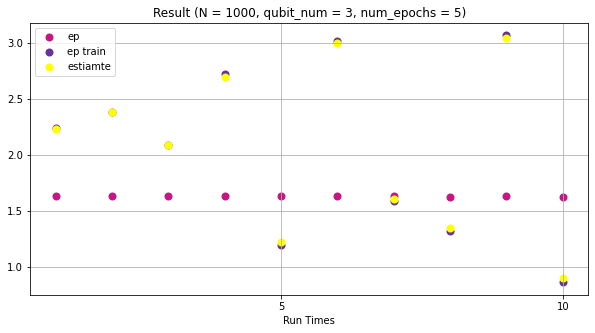

平均時間 : 19.6375


In [5]:
plt.figure(figsize=(10,5))
plt.title("Result (N = 1000, qubit_num = 3, num_epochs = 5)")
tl = []
for i in times_list_1:
    if i % 5 == 0:
        tl.append(i)

plt.scatter(times_list_1, ep_list_1, label='ep', color='mediumvioletred', linewidth=2)
plt.scatter(times_list_1, ep_train_list_1, label='ep train', color='rebeccapurple', linewidth=2)
plt.scatter(times_list_1, estimate_list_1, label='estiamte', color='yellow', linewidth=2)

plt.grid()
plt.legend(loc='best')
plt.xticks(tl) 
plt.xlabel('Run Times')
plt.show()
print('平均時間 :',run_time_1/len(times_list_1))

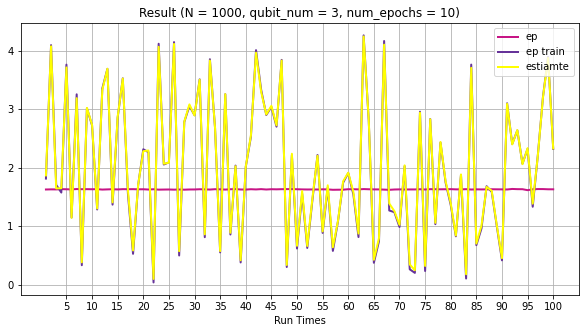

平均時間 : 76.44203125


In [17]:
plt.figure(figsize=(10,5))
plt.title("Result (N = 1000, qubit_num = 3, num_epochs = 10)")
tl = []
for i in times_list_2:
    if i % 5 == 0:
        tl.append(i)
plt.scatter(times_list_2, ep_list_2, label='ep', color='mediumvioletred', linewidth=2)
plt.scatter(times_list_2, ep_train_list_2, label='ep train', color='rebeccapurple', linewidth=2)
plt.scatter(times_list_2, estimate_list_2, label='estiamte', color='yellow', linewidth=2)

plt.grid()
plt.legend(loc='best')
plt.xticks(tl) 
plt.xlabel('Run Times')
plt.show()
print('平均時間 :',run_time_2/len(times_list_2))

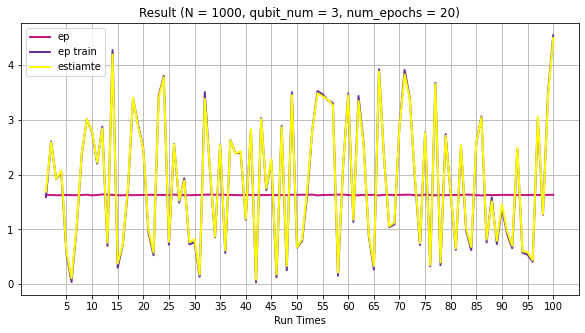

平均時間 : 312.489375


In [16]:
plt.figure(figsize=(10,5))
plt.title("Result (N = 1000, qubit_num = 3, num_epochs = 20)")
tl = []
for i in times_list_3:
    if i % 5 == 0:
        tl.append(i)
plt.scatter(times_list_3, ep_list_3, label='ep', color='mediumvioletred', linewidth=2)
plt.scatter(times_list_3, ep_train_list_3, label='ep train', color='rebeccapurple', linewidth=2)
plt.scatter(times_list_3, estimate_list_3, label='estiamte', color='yellow', linewidth=2)

plt.grid()
plt.legend(loc='best')
plt.xticks(tl) 
plt.xlabel('Run Times')
plt.show()
print('平均時間 :',run_time_3/len(times_list_3))

In [6]:
print(in_ci_1)
#print(in_ci_2)
#print(in_ci_3)
#print(run_time_1)
#print(run_time_2)
#print(run_time_3)
#print(len(times_list_1))
#print(len(times_list_2))
#print(len(times_list_3))

1
